In [1]:
import pandas as pd
import matplotlib.pylab as plt
import glob
import numpy as np
from tqdm.notebook import tqdm

from matplotlib.cm import rainbow

from scipy.special import gamma

from joblib import Parallel, delayed

In [20]:
def variance_ratio(q_position, df: pd.DataFrame):
    MR = list()

    result_array = list()
    q_array = list()
    #   Create time_lags like 2 ** k
    #time_lags = [1] + [2 ** i for i in range(1, q_position+1)]
    log_prices = np.log(df.close.dropna())
    ret = np.log(df.close.dropna())
    #ret = ret.pct_change()[1:].dropna()
    #ret = ret.diff().dropna()
    ret = ret.diff().dropna()
    time_lags = np.arange(1, 2 ** q_position, 50)
    for EA, time_lag in tqdm(enumerate(time_lags), total=len(time_lags), leave=False):
        buff_size = len(ret)
        means = (1 / buff_size) * np.sum(ret)
        m = time_lag * (buff_size - time_lag + 1) * (1 - (time_lag / buff_size))
        sigma_a = (1 / (buff_size - 1)) * np.sum(np.square(ret - means))
        subtract_returns = np.subtract(log_prices, np.roll(log_prices, time_lag))[time_lag:]
        _buff_ = np.sum(np.square(subtract_returns - time_lag * means))
        sigma_b = (1 / m) * _buff_
        result = (sigma_b / sigma_a)
        plt.plot(time_lag, result, 'o', color='white')
        plt.grid(alpha=.1)
        result_array.append(result)
        q_array.append(time_lag)
    return result_array, q_array


RESULTS = list()
files = glob.glob('zip_data/*.csv')[:]
colors = rainbow(np.linspace(0, 1, len(files)))

def _estimator(_):
    """
    :param arrow: Need for color
    :param _: Name of file
    :return: name, res, q in tuple
    """
    name = _.split('/')[1][:-4]
    if name not in ['ES-21.12', 'NQ-21.12']:
        data = pd.read_csv(_)
        res, q = variance_ratio(10, data.dropna())
        #plt.plot(q, res, '--', color=colors[arrow], linewidth=5, label=name)
        return [name, res, q]

def beauty_plotter(res):
    for arrow, plotting in enumerate(res):
        if plotting:
            print(plotting)
            plt.plot(plotting[2], plotting[1], '--', color=colors[arrow], linewidth=5, label=plotting[0])
RESULTS = Parallel(n_jobs=-1, verbose=0)(delayed(_estimator)(_) for _ in tqdm(files, total=len(files)))

  0%|          | 0/15 [00:00<?, ?it/s]

['AUDCAD', [1.0, 0.7238959928289773, 0.6951780874129361, 0.686162277664645, 0.6812628790067582, 0.6737248798909139, 0.6642467200205994, 0.6562794522281642, 0.6518749962401535, 0.6481750710301679, 0.6445110612123423, 0.6440844331532113, 0.6437747417730145, 0.6427081731340902, 0.641578954601812, 0.6398994911533404, 0.6371207359822314, 0.6335487765089569, 0.6300321357763153, 0.6279365127844012, 0.6262534329673812], [1, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601, 651, 701, 751, 801, 851, 901, 951, 1001]]
['EURUSD', [1.0, 0.8957234076732412, 0.8817934066151685, 0.8752664814520599, 0.8718816164603181, 0.8681109800822762, 0.8606469317187447, 0.8553506380181383, 0.8530867904051024, 0.8495077500147458, 0.8455720878546102, 0.841194474512204, 0.8375239503978956, 0.8346363892009769, 0.8321922451706111, 0.8295694535278216, 0.8279579559133965, 0.8254762533734953, 0.8216982810442823, 0.819193588572226, 0.8175116259767848], [1, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601, 

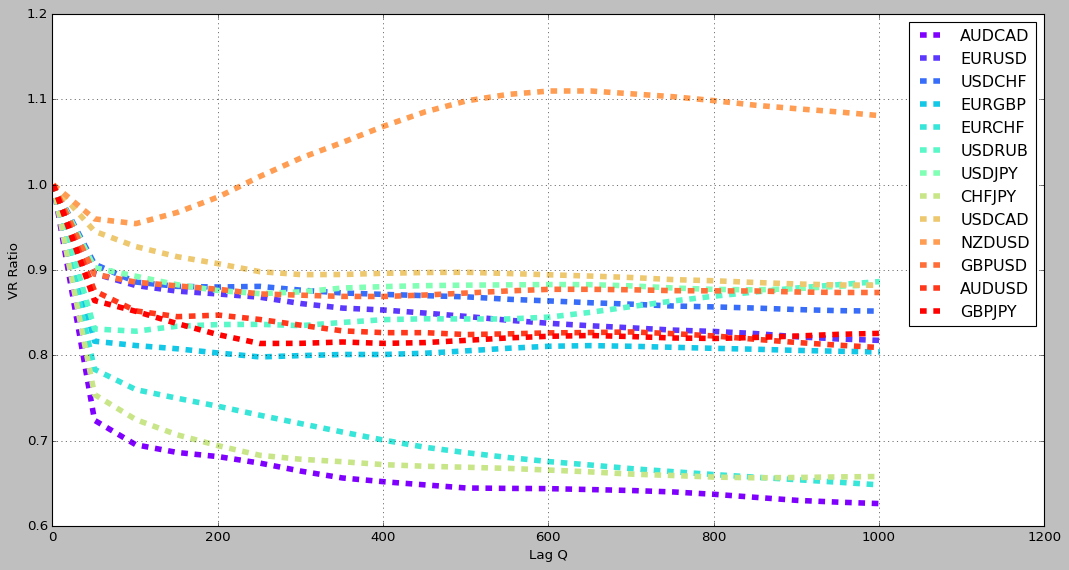

In [21]:
plt.figure(figsize=(16,8))
plt.grid()
plt.ylabel('VR Ratio')
plt.xlabel('Lag Q')
plt.style.use('classic')
beauty_plotter(RESULTS)
plt.legend()
plt.show()
